In [1]:
import tensorflow as tf
from tensorflow.contrib import predictor

export_dir = "gs://neural-guidance-tensorflow/export/henryk-sr-30-ngu-tpu-08/1551195315"
predict_fn = predictor.from_saved_model(export_dir)



INFO:tensorflow:Restoring parameters from gs://neural-guidance-tensorflow/export/henryk-sr-30-ngu-tpu-08/1551195315/variables/variables


In [2]:
from matplotlib import pyplot as plt
import numpy as np

In [3]:
import sys 
sys.path.insert(0,'..')

In [4]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [5]:
np.set_printoptions(precision=2, suppress=True)

In [6]:
import tensorflow as tf
import os

BATCH_SIZE = 1

In [7]:
np.set_printoptions(precision=3, suppress=True)

In [8]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        # policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [9]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [10]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [11]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [12]:
def print_all(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    if light == False:
        compute_and_print_steps(sats, RandomVarDPLL)
        compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, HybridDPLL)
    if light == False:
        compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush()

 20%|██        | 2/10 [00:00<00:00, 16.64it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 21.33it/s]


#Sats: 10; avg step: 992.50; stdev step: 418.20; avg error: 7.70; stdev error: 2.10


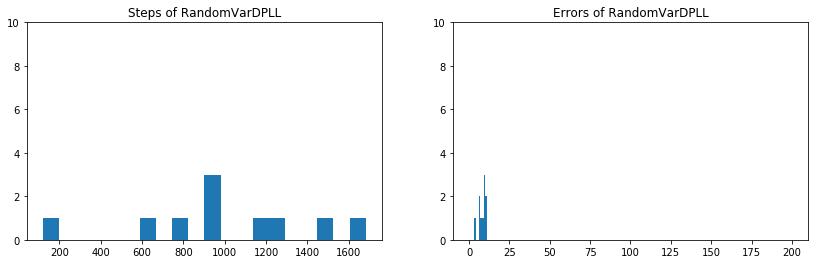

100%|██████████| 10/10 [00:00<00:00, 36.37it/s]


#Sats: 10; avg step: 574.70; stdev step: 282.53; avg error: 4.80; stdev error: 1.94


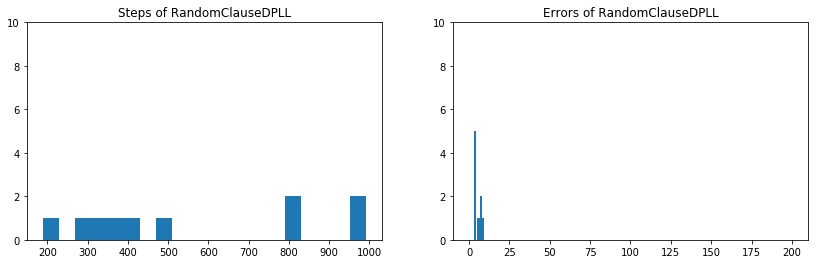

100%|██████████| 10/10 [00:16<00:00,  1.43s/it]


#Sats: 10; avg step: 93.70; stdev step: 223.29; avg error: 0.40; stdev error: 0.92


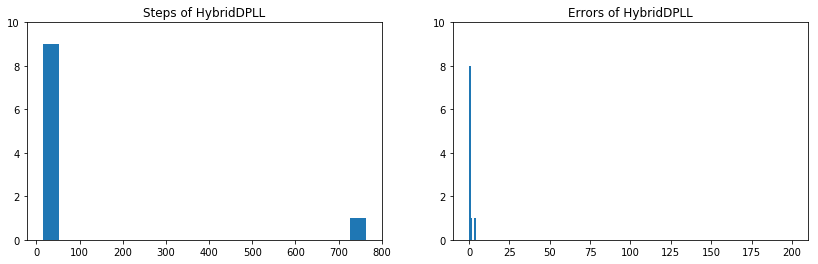

100%|██████████| 10/10 [00:23<00:00,  6.01s/it]


#Sats: 10; avg step: 174.50; stdev step: 465.59; avg error: 0.20; stdev error: 0.40


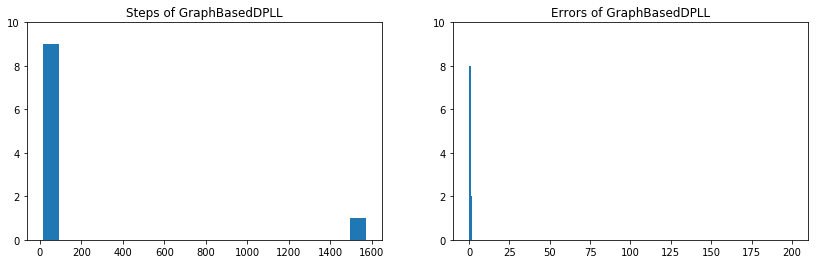

100%|██████████| 10/10 [00:00<00:00, 50.15it/s]


#Sats: 10; avg step: 301.50; stdev step: 178.06; avg error: 2.50; stdev error: 0.92


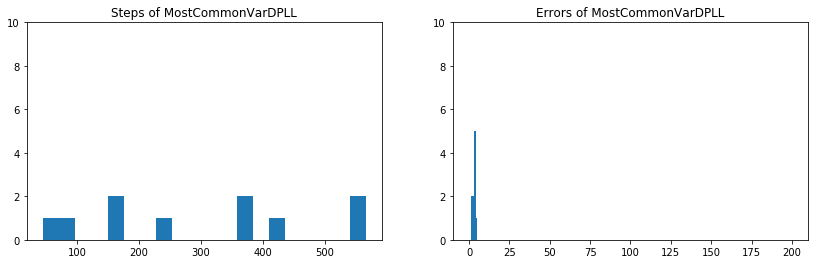

In [13]:
print_all(10, 200, 15)

100%|██████████| 10/10 [00:00<00:00, 425.48it/s]

We have generated 10 formulas
#Sats: 10; avg step: 73.70; stdev step: 38.63; avg error: 3.80; stdev error: 1.40


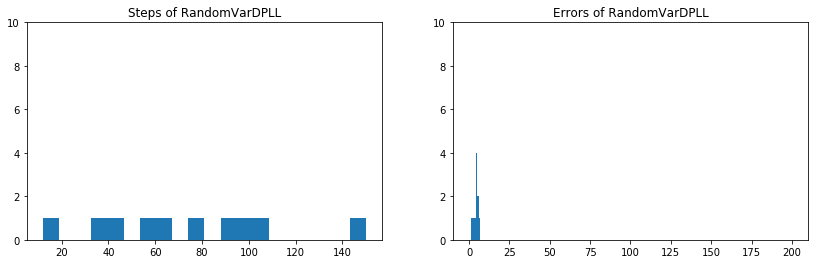

100%|██████████| 10/10 [00:00<00:00, 435.95it/s]


#Sats: 10; avg step: 63.90; stdev step: 30.29; avg error: 2.60; stdev error: 1.69


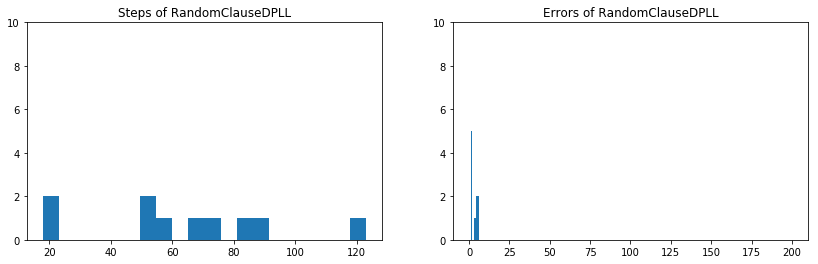

100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


#Sats: 10; avg step: 9.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


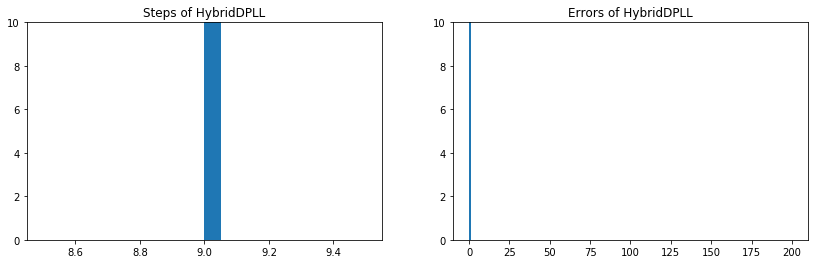

100%|██████████| 10/10 [00:01<00:00,  5.46it/s]


#Sats: 10; avg step: 9.00; stdev step: 0.00; avg error: 0.00; stdev error: 0.00


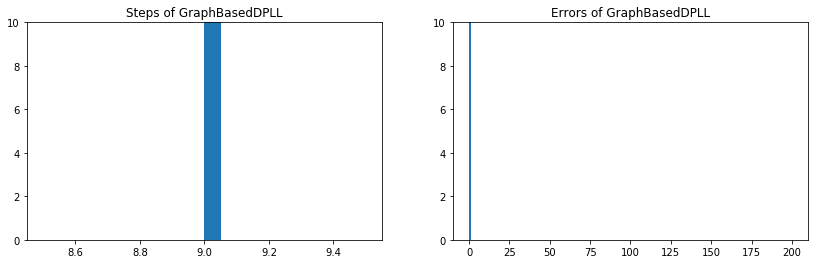

100%|██████████| 10/10 [00:00<00:00, 905.82it/s]


#Sats: 10; avg step: 18.30; stdev step: 10.47; avg error: 0.60; stdev error: 0.66


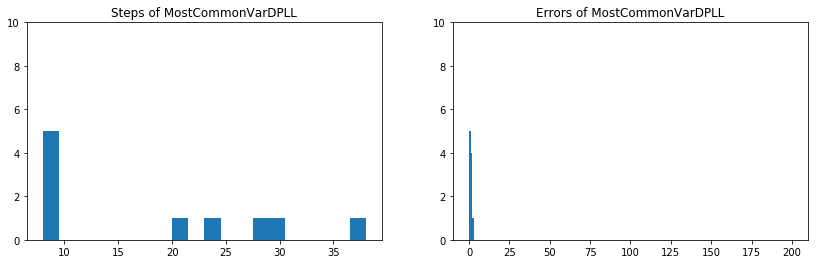

In [14]:
print_all(10, 200, 8)

100%|██████████| 10/10 [00:00<00:00, 251.95it/s]

We have generated 10 formulas
#Sats: 10; avg step: 107.40; stdev step: 71.39; avg error: 5.20; stdev error: 1.89


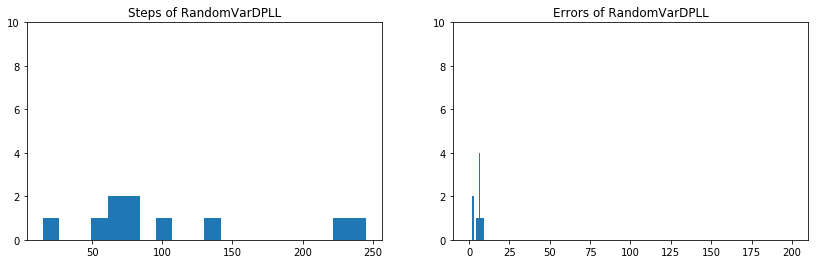

100%|██████████| 10/10 [00:00<00:00, 275.31it/s]


#Sats: 10; avg step: 88.90; stdev step: 48.19; avg error: 2.90; stdev error: 1.22


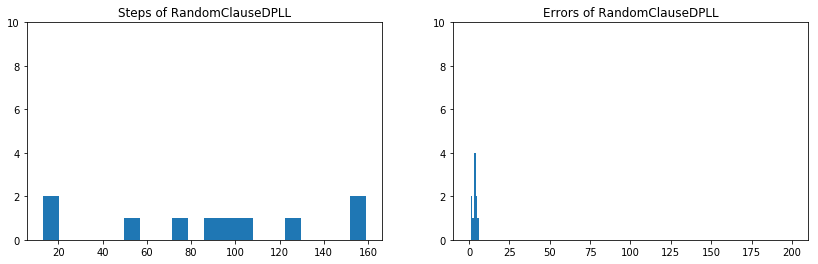

100%|██████████| 10/10 [00:04<00:00,  2.17it/s]


#Sats: 10; avg step: 12.60; stdev step: 5.14; avg error: 0.10; stdev error: 0.30


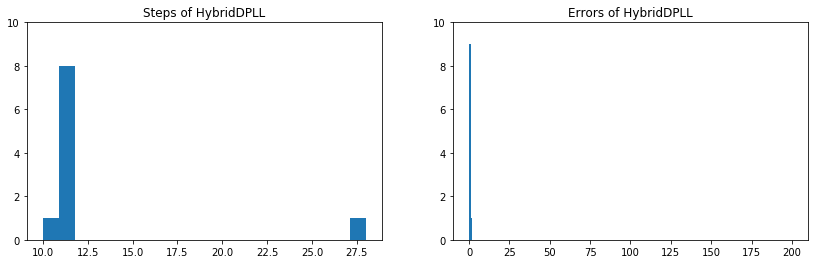

100%|██████████| 10/10 [00:04<00:00,  2.18it/s]


#Sats: 10; avg step: 12.60; stdev step: 5.14; avg error: 0.10; stdev error: 0.30


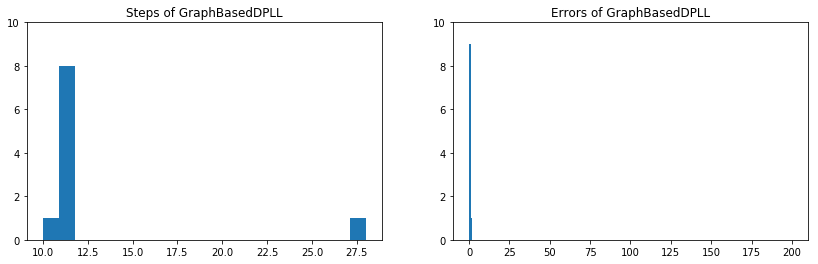

100%|██████████| 10/10 [00:00<00:00, 410.56it/s]


#Sats: 10; avg step: 37.80; stdev step: 33.59; avg error: 1.20; stdev error: 1.08


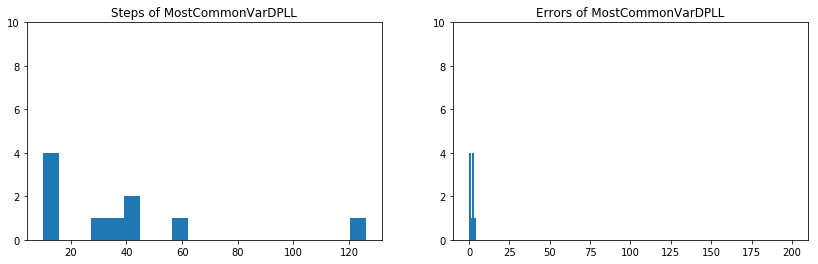

In [15]:
print_all(10, 200, 10)

100%|██████████| 10/10 [00:00<00:00, 106.76it/s]

We have generated 10 formulas
#Sats: 10; avg step: 228.60; stdev step: 110.18; avg error: 6.20; stdev error: 1.66


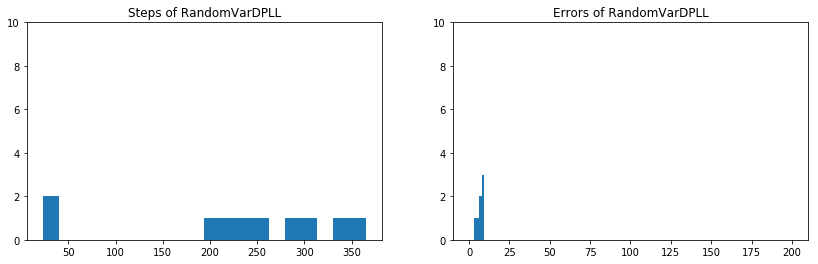

100%|██████████| 10/10 [00:00<00:00, 97.96it/s]


#Sats: 10; avg step: 240.00; stdev step: 170.61; avg error: 4.20; stdev error: 1.17


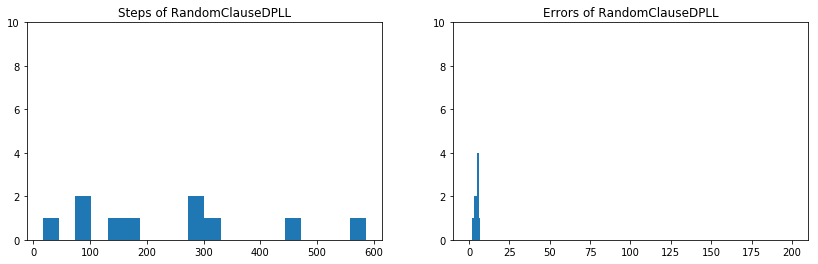

100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


#Sats: 10; avg step: 12.80; stdev step: 0.40; avg error: 0.00; stdev error: 0.00


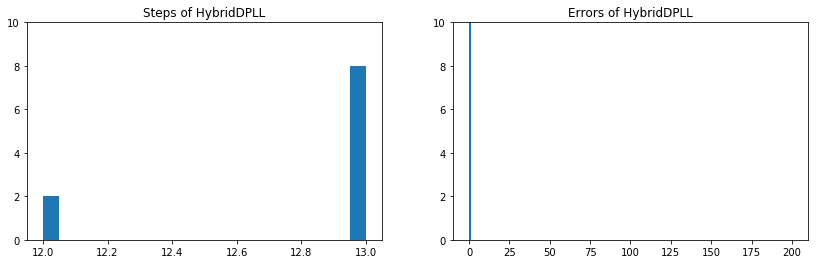

100%|██████████| 10/10 [00:04<00:00,  2.22it/s]


#Sats: 10; avg step: 12.80; stdev step: 0.40; avg error: 0.00; stdev error: 0.00


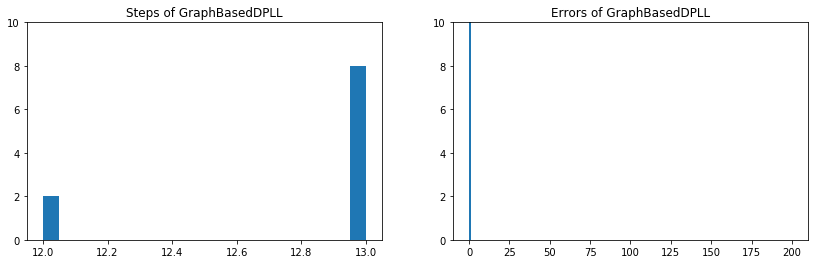

100%|██████████| 10/10 [00:00<00:00, 167.54it/s]


#Sats: 10; avg step: 86.50; stdev step: 67.90; avg error: 1.60; stdev error: 1.11


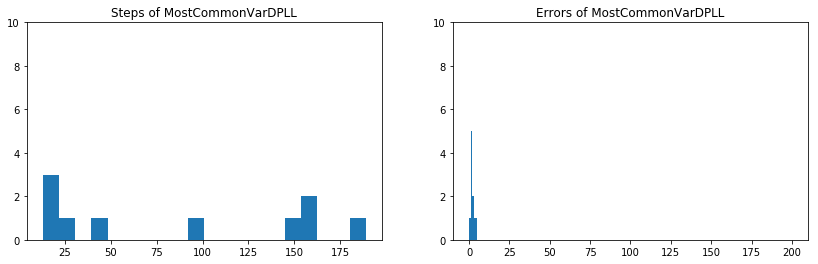

In [16]:
print_all(10, 200, 12)

 60%|██████    | 6/10 [00:00<00:00, 47.26it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 38.93it/s]


#Sats: 10; avg step: 592.40; stdev step: 380.42; avg error: 6.40; stdev error: 1.43


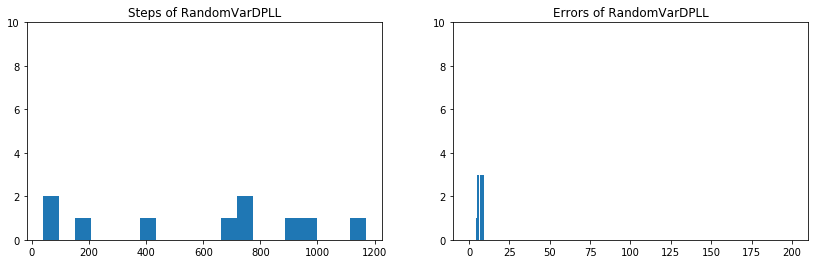

100%|██████████| 10/10 [00:00<00:00, 42.07it/s]


#Sats: 10; avg step: 490.50; stdev step: 237.39; avg error: 3.80; stdev error: 1.47


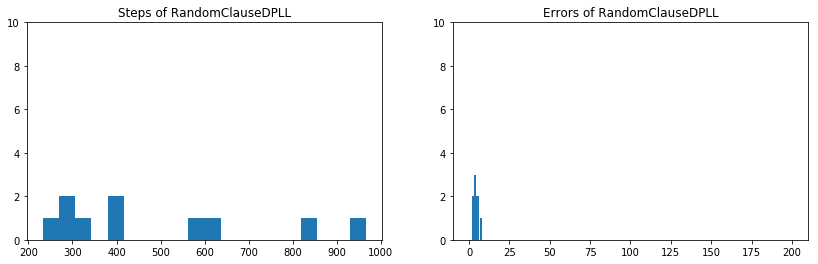

100%|██████████| 10/10 [00:13<00:00,  1.17it/s]


#Sats: 10; avg step: 135.80; stdev step: 207.41; avg error: 1.00; stdev error: 1.79


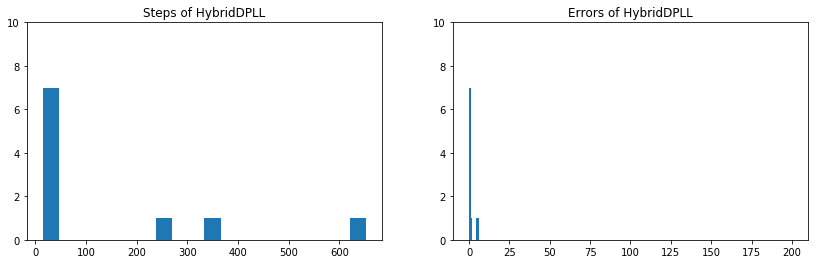

100%|██████████| 10/10 [00:41<00:00,  1.64s/it]


#Sats: 10; avg step: 239.60; stdev step: 390.56; avg error: 0.40; stdev error: 0.66


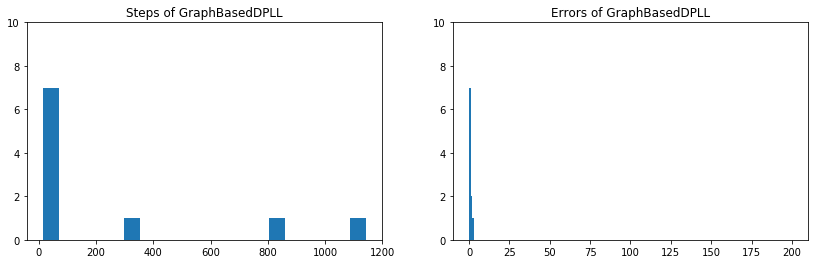

100%|██████████| 10/10 [00:00<00:00, 104.20it/s]


#Sats: 10; avg step: 141.90; stdev step: 152.23; avg error: 2.10; stdev error: 1.70


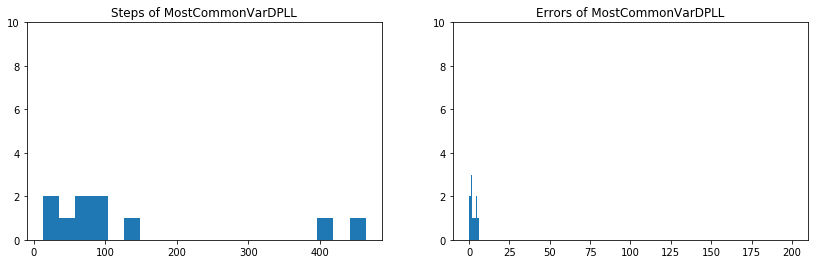

In [17]:
print_all(10, 200, 14)

 20%|██        | 2/10 [00:00<00:00, 13.16it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 14.42it/s]


#Sats: 10; avg step: 1613.20; stdev step: 454.37; avg error: 8.40; stdev error: 1.50


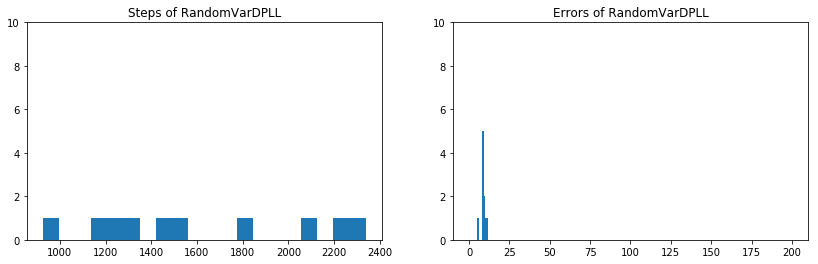

100%|██████████| 10/10 [00:00<00:00, 20.50it/s]


#Sats: 10; avg step: 977.40; stdev step: 594.69; avg error: 5.60; stdev error: 1.50


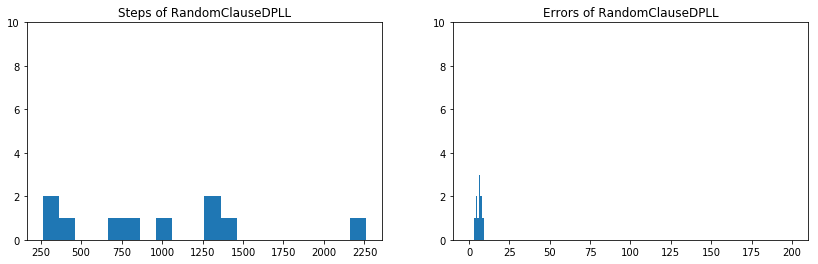

100%|██████████| 10/10 [00:11<00:00,  1.07it/s]


#Sats: 10; avg step: 138.10; stdev step: 277.21; avg error: 0.70; stdev error: 1.42


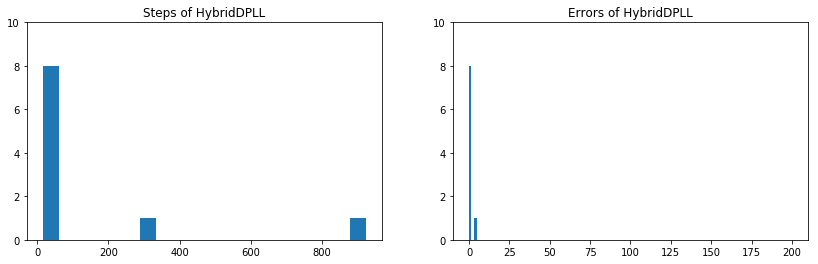

100%|██████████| 10/10 [00:54<00:00,  2.90s/it]


#Sats: 10; avg step: 314.40; stdev step: 695.69; avg error: 0.20; stdev error: 0.40


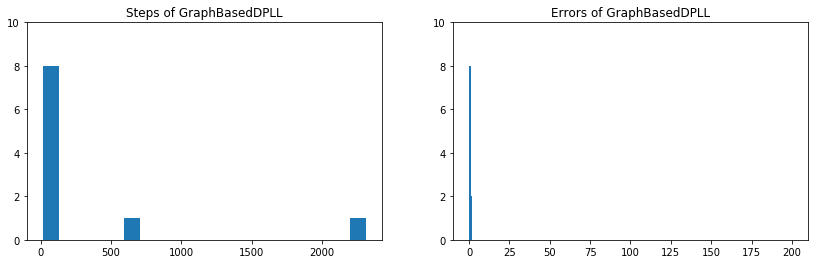

100%|██████████| 10/10 [00:01<00:00,  9.62it/s]


#Sats: 10; avg step: 226.30; stdev step: 306.59; avg error: 2.30; stdev error: 1.55


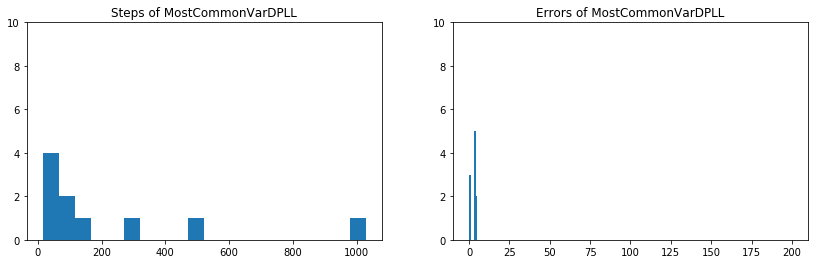

In [18]:
print_all(10, 200, 16)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 11.26it/s]


#Sats: 10; avg step: 1806.50; stdev step: 1454.70; avg error: 9.10; stdev error: 2.02


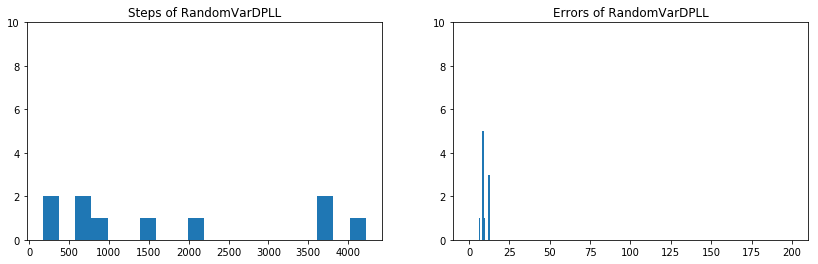

100%|██████████| 10/10 [00:00<00:00, 12.55it/s]


#Sats: 10; avg step: 1516.10; stdev step: 971.69; avg error: 4.80; stdev error: 1.66


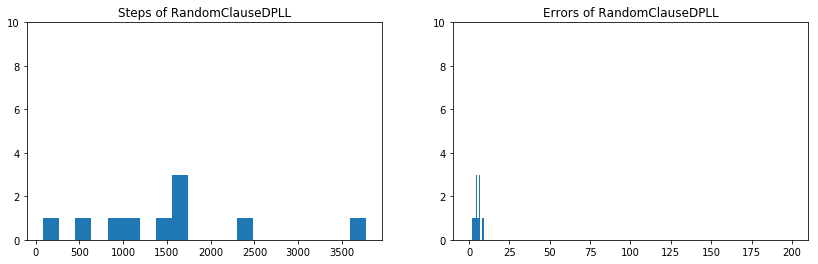

100%|██████████| 10/10 [00:10<00:00,  1.56s/it]


#Sats: 10; avg step: 56.10; stdev step: 111.63; avg error: 0.30; stdev error: 0.90


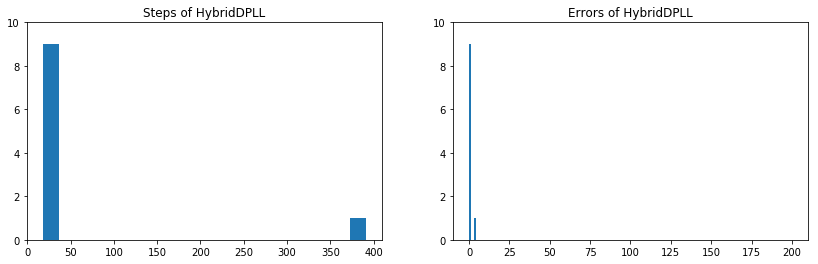

100%|██████████| 10/10 [00:19<00:00,  4.29s/it]


#Sats: 10; avg step: 92.60; stdev step: 221.13; avg error: 0.10; stdev error: 0.30


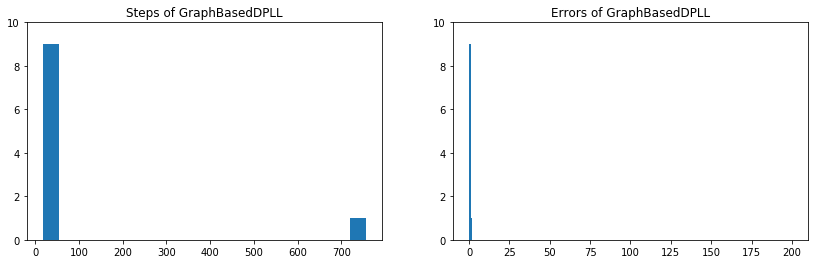

100%|██████████| 10/10 [00:00<00:00, 28.29it/s]


#Sats: 10; avg step: 534.90; stdev step: 398.02; avg error: 3.30; stdev error: 1.00


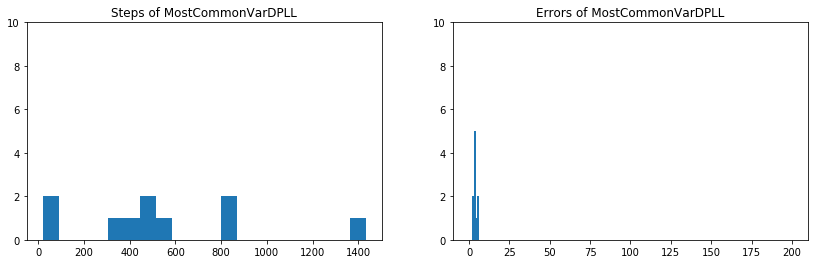

In [19]:
print_all(10, 200, 18)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:02<00:00,  2.61it/s]


#Sats: 10; avg step: 5812.40; stdev step: 3947.69; avg error: 9.50; stdev error: 1.80


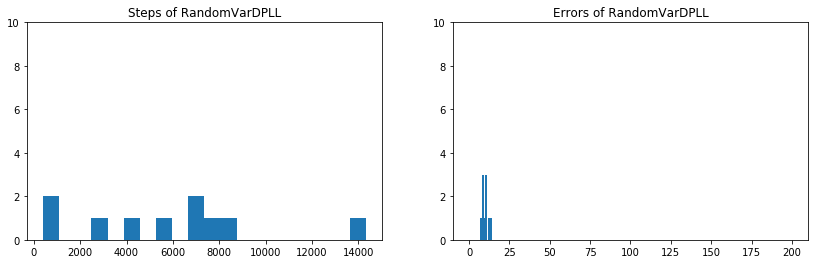

100%|██████████| 10/10 [00:01<00:00,  5.06it/s]


#Sats: 10; avg step: 3018.20; stdev step: 2002.64; avg error: 5.90; stdev error: 2.30


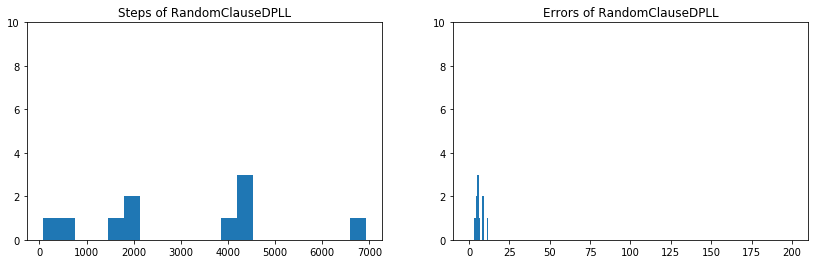

100%|██████████| 10/10 [00:20<00:00,  1.96s/it]


#Sats: 10; avg step: 615.20; stdev step: 821.17; avg error: 1.60; stdev error: 2.20


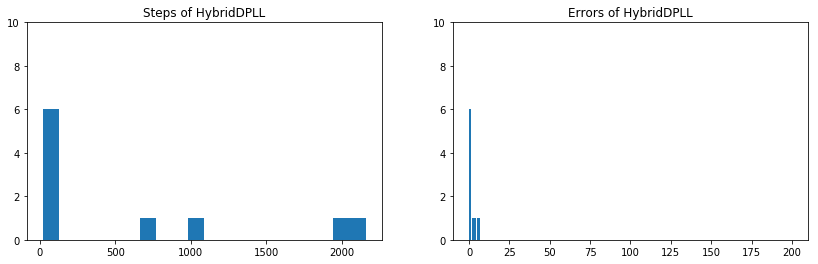

100%|██████████| 10/10 [07:39<00:00, 53.24s/it]


#Sats: 10; avg step: 2676.30; stdev step: 3821.41; avg error: 0.50; stdev error: 0.67


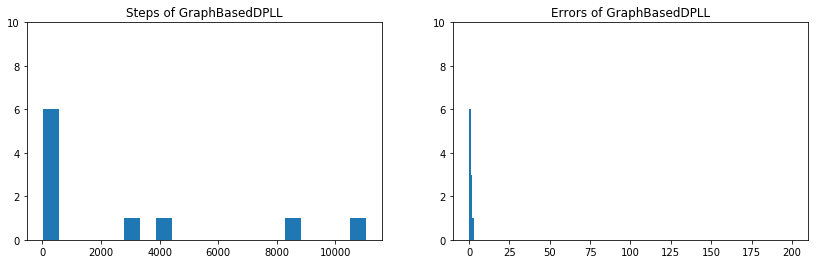

100%|██████████| 10/10 [00:00<00:00, 10.67it/s]


#Sats: 10; avg step: 1184.70; stdev step: 566.23; avg error: 3.30; stdev error: 1.19


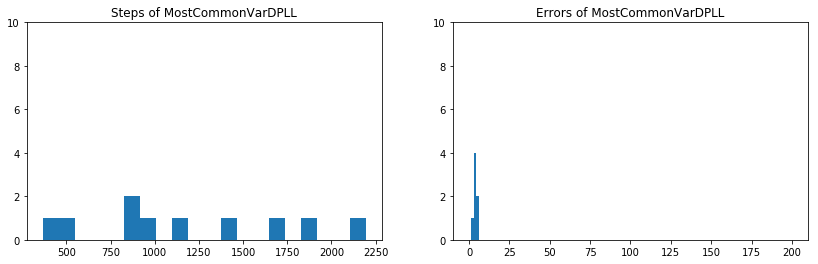

In [20]:
print_all(10, 200, 20)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:12<00:00,  1.10s/it]


#Sats: 10; avg step: 20014.50; stdev step: 24376.13; avg error: 12.40; stdev error: 2.20


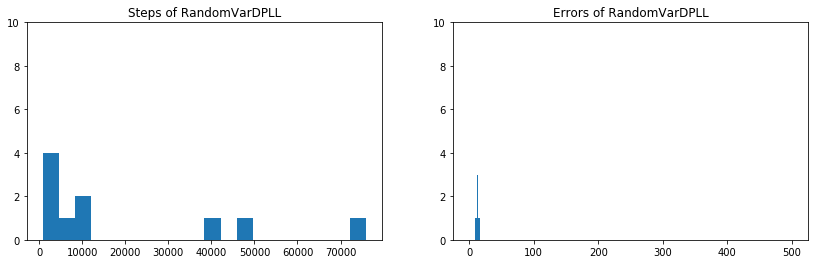

100%|██████████| 10/10 [00:11<00:00,  1.51s/it]


#Sats: 10; avg step: 14683.10; stdev step: 6497.06; avg error: 7.70; stdev error: 2.10


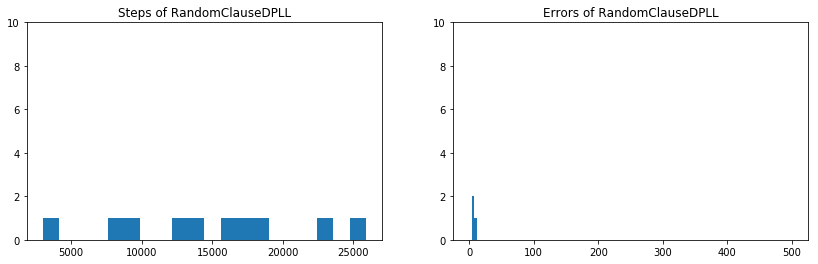

100%|██████████| 10/10 [00:17<00:00,  1.94s/it]


#Sats: 10; avg step: 755.70; stdev step: 1941.55; avg error: 0.80; stdev error: 1.54


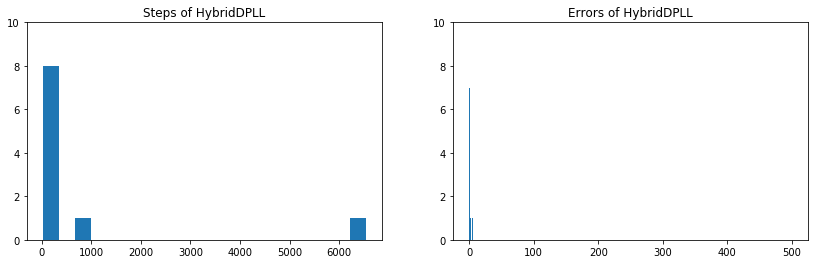

100%|██████████| 10/10 [15:58<00:00, 171.54s/it]


#Sats: 10; avg step: 5519.30; stdev step: 13794.99; avg error: 0.30; stdev error: 0.46


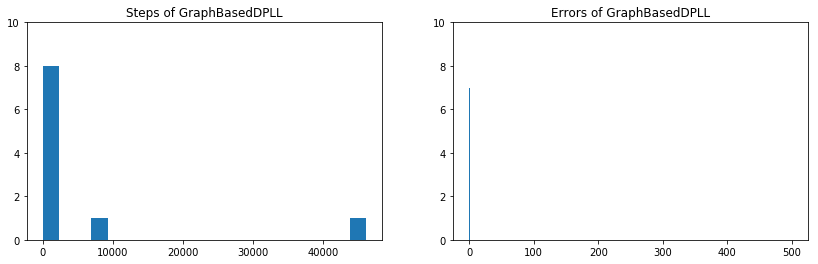

100%|██████████| 10/10 [00:02<00:00,  3.82it/s]


#Sats: 10; avg step: 2664.60; stdev step: 2148.43; avg error: 3.10; stdev error: 1.22


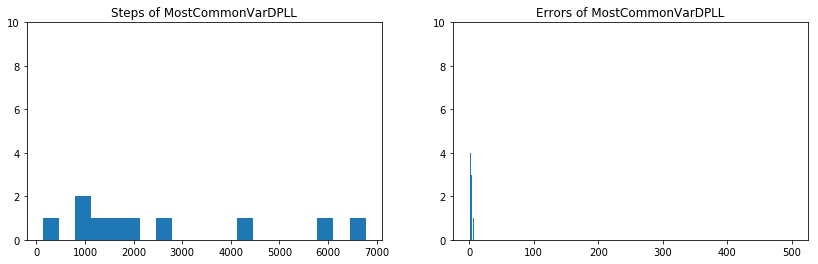

In [21]:
print_all(10, 500, 25)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:24<00:00,  3.35s/it]


#Sats: 10; avg step: 6650.70; stdev step: 13478.41; avg error: 1.60; stdev error: 2.50


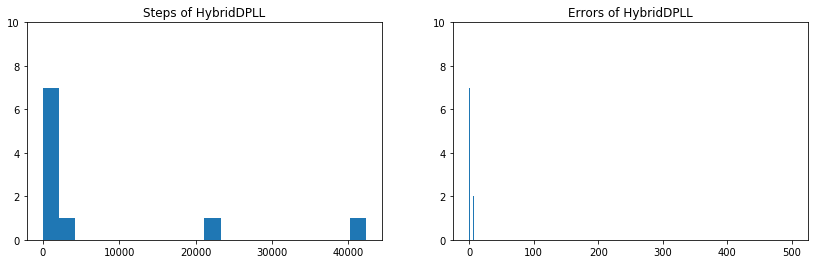

100%|██████████| 10/10 [00:13<00:00,  1.45s/it]


#Sats: 10; avg step: 11025.60; stdev step: 7060.04; avg error: 4.70; stdev error: 2.45


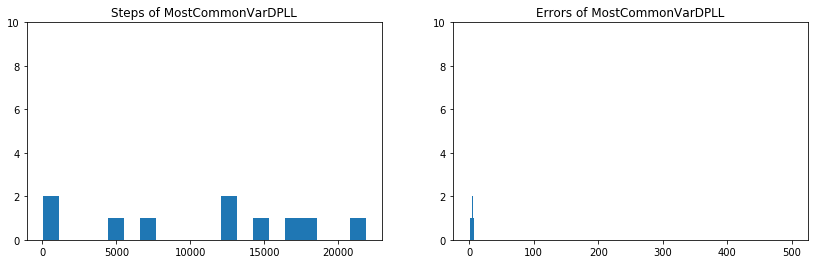

In [22]:
print_all(10, 500, 30, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:57<00:00,  6.49s/it]


#Sats: 10; avg step: 21960.80; stdev step: 51487.31; avg error: 3.00; stdev error: 3.26


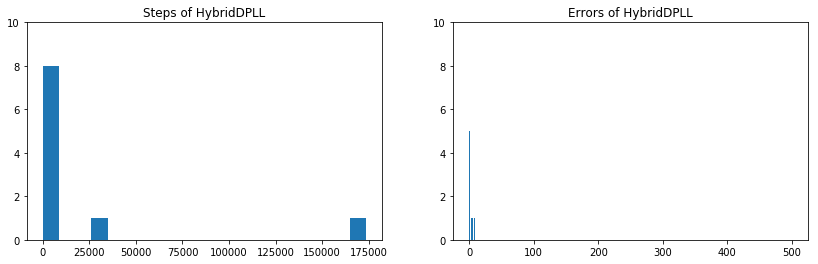

100%|██████████| 10/10 [03:04<00:00, 22.80s/it]


#Sats: 10; avg step: 132116.40; stdev step: 199870.43; avg error: 6.10; stdev error: 1.51


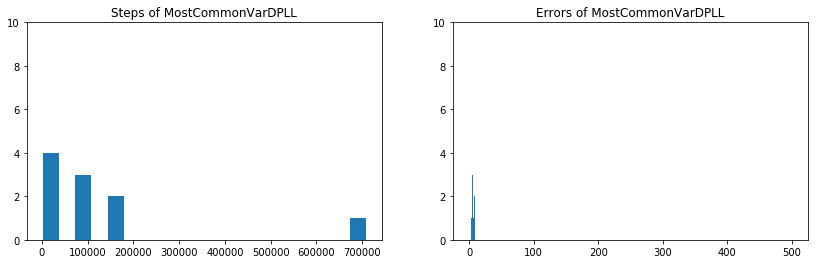

In [23]:
print_all(10, 500, 40, light=True)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [01:13<00:00,  6.62s/it]


#Sats: 10; avg step: 26953.30; stdev step: 67407.81; avg error: 2.40; stdev error: 3.10


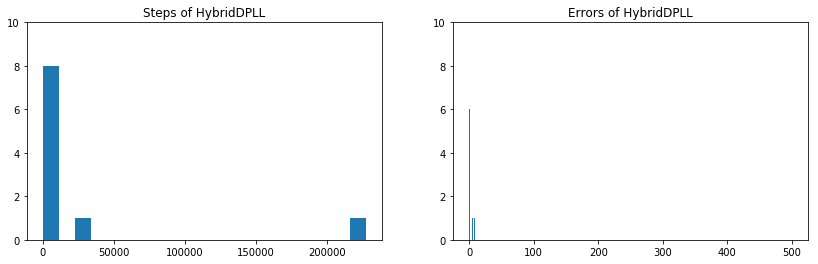

100%|██████████| 10/10 [1:04:23<00:00, 281.62s/it]


#Sats: 10; avg step: 2315676.10; stdev step: 3143752.97; avg error: 7.20; stdev error: 1.89


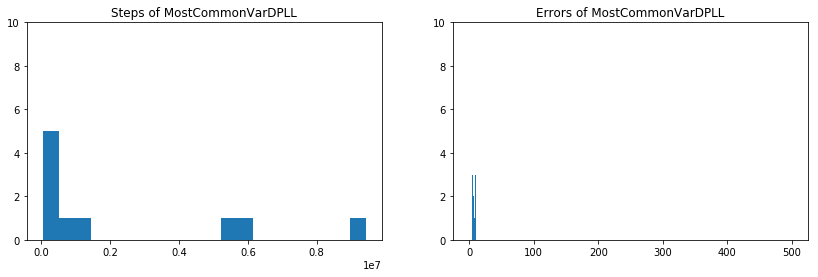

In [24]:
print_all(10, 500, 50, light=True)